In [1]:
import pandas as pd
import numpy as np
import sys 
import datetime
import os
import matplotlib as plt
import seaborn as sns

%matplotlib inline

# Process the Weekday data

## Averages data for Jan and Feb 2019

* Average weekday non-pooled trip totals 
* Average weekday pooled trip totals
* Average weekday fares
* Average weekday travel time


In [2]:
tods = [1,2,3,4,5,6,7,8]

In [3]:
agg = { 'Trip Seconds':'mean',
       'Trip Miles':'mean','Fare':'mean',
       'Tip':'mean', 'Additional Charges':'mean', 'Trip Total':'mean', 'PRIVATE_TRIPS':'sum','SHARED_TRIPS':'sum',
       'Trips Pooled':'sum'}


In [6]:
df_all = pd.DataFrame()
df_raw = pd.DataFrame()

for tod in tods:
    print('Working on tod ' + str(tod))
    df = pd.read_hdf('C:/Workspace/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/Old Files/Chicago_TNC_Trips_20_Incomplete.H5', key = 'Weekday_' + str(tod))

    df = df[df['MONTH'].isin([1,2])]
    df = df[df['YEAR']==2019]
    
    print(df['Trip Seconds'].max())
    print(df['Trip Miles'].max())
    
    df = df.dropna(subset = ['Pickup Census Tract', 'Dropoff Census Tract'])
    df['DAY'] = df['Trip Start Timestamp'].dt.day
    df['PRIVATE_TRIPS'] = np.where(df['Shared Trip Authorized'] == False, 1, 0)
    df['SHARED_TRIPS'] = np.where(df['Shared Trip Authorized'] == True, 1, 0)  
    
    ## the filters are higher than the longest trip because the trip could be pooled
    # filter out the trips that are longer than 50 miles becuase the longest possible trip is 35 miles going from O'Hare airport to south east corner
    df2 = df[df['Trip Miles'] <= 50]
    
    # filter out the trips that are longer than 2 hours becuase the longest possible trip is 1 hours going from O'Hare airport to south east corner
    df2 = df2[df2['Trip Seconds'] <= 7200]
    
    print(df2['Trip Seconds'].max())
    print(df2['Trip Miles'].max())
    
    df2 = df2.groupby(by= ['Pickup Census Tract','Dropoff Census Tract','MONTH','DAY'], as_index =False).agg(agg)
    df2 = df2.groupby(by= ['Pickup Census Tract','Dropoff Census Tract'], as_index =False).mean()
    
    df['TOD'] = tod
    df2['TOD'] = tod

    df_raw = df_raw.append(df)
    df_all = df_all.append(df2)

Working on tod 1
55117.0
296.9
7158.0
49.8
Working on tod 2
29520.0
205.2
7093.0
48.5
Working on tod 3
78780.0
266.1
7198.0
49.5
Working on tod 4
27660.0
335.5
7003.0
49.8
Working on tod 5
80520.0
304.7
7186.0
49.6
Working on tod 6
35751.0
295.6
7144.0
49.1
Working on tod 7
77040.0
294.7
7195.0
50.0
Working on tod 8
73200.0
262.0
7159.0
49.7


## Add in the Suppressed Trips

In [34]:
sup_trips = pd.read_csv('C:/Workspace/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/2019 Suppressed Trips.csv')

In [35]:
df_all.head()

,Pickup Census Tract,Dropoff Census Tract,MONTH,DAY,Trip Seconds,Trip Miles,Fare,Tip,Additional Charges,Trip Total,PRIVATE_TRIPS,SHARED_TRIPS,Trips Pooled,TOD
0,1.703101e+10,1.703101e+10,1.437500,14.625000,397.496875,1.235417,4.580729,0.770833,2.276719,7.628281,1.500000,0.437500,1.937500,1
1,1.703101e+10,1.703101e+10,1.500000,15.269231,275.250000,1.009615,3.605769,0.076923,2.400962,6.083654,0.807692,0.500000,1.576923,1
2,1.703101e+10,1.703101e+10,1.400000,16.100000,236.200000,0.570000,3.000000,0.100000,2.035000,5.135000,0.400000,0.800000,1.400000,1
3,1.703101e+10,1.703101e+10,1.454545,14.272727,206.136364,0.718182,3.409091,0.090909,2.086364,5.586364,0.909091,0.363636,1.454545,1
4,1.703101e+10,1.703101e+10,1.714286,10.142857,370.738095,1.483333,5.119048,0.595238,1.453571,7.167857,0.500000,0.642857,1.357143,1


In [36]:
sup_trips.head()

,Unnamed: 0,GEOID_PICKUP,GEOID_DROPOFF,TOD,SCALED_SUP_PRIVATE_TRIPS,SCALED_SUP_SHARED_TRIPS,Pickup Community Area,Dropoff Community Area
0,0,17031010100,17031010100,1,0.505081,0.238328,1.0,1.0
1,1,17031010100,17031010100,2,0.014279,0.007501,1.0,1.0
2,2,17031010100,17031010100,3,0.085216,0.034086,1.0,1.0
3,3,17031010100,17031010100,4,0.048413,0.023284,1.0,1.0
4,4,17031010100,17031010100,5,0.052144,0.028676,1.0,1.0


In [37]:
df_final = df_all.merge(sup_trips[['GEOID_PICKUP', 'GEOID_DROPOFF', 'SCALED_SUP_PRIVATE_TRIPS', 'SCALED_SUP_SHARED_TRIPS', 'TOD']], how = 'left', left_on = ['Pickup Census Tract','Dropoff Census Tract', 'TOD'],right_on = ['GEOID_PICKUP', 'GEOID_DROPOFF', 'TOD'])

In [38]:
df_final.head()

,Pickup Census Tract,Dropoff Census Tract,MONTH,DAY,Trip Seconds,Trip Miles,Fare,Tip,Additional Charges,Trip Total,PRIVATE_TRIPS,SHARED_TRIPS,Trips Pooled,TOD,GEOID_PICKUP,GEOID_DROPOFF,SCALED_SUP_PRIVATE_TRIPS,SCALED_SUP_SHARED_TRIPS
0,1.703101e+10,1.703101e+10,1.437500,14.625000,397.496875,1.235417,4.580729,0.770833,2.276719,7.628281,1.500000,0.437500,1.937500,1,1.703101e+10,1.703101e+10,0.505081,0.238328
1,1.703101e+10,1.703101e+10,1.500000,15.269231,275.250000,1.009615,3.605769,0.076923,2.400962,6.083654,0.807692,0.500000,1.576923,1,1.703101e+10,1.703101e+10,0.032476,0.015324
2,1.703101e+10,1.703101e+10,1.400000,16.100000,236.200000,0.570000,3.000000,0.100000,2.035000,5.135000,0.400000,0.800000,1.400000,1,1.703101e+10,1.703101e+10,0.022509,0.010621
3,1.703101e+10,1.703101e+10,1.454545,14.272727,206.136364,0.718182,3.409091,0.090909,2.086364,5.586364,0.909091,0.363636,1.454545,1,1.703101e+10,1.703101e+10,0.938195,0.442698
4,1.703101e+10,1.703101e+10,1.714286,10.142857,370.738095,1.483333,5.119048,0.595238,1.453571,7.167857,0.500000,0.642857,1.357143,1,1.703101e+10,1.703101e+10,0.207765,0.098036


In [39]:
df_final['SHARED_TRIPS'] = df_final['SHARED_TRIPS'] + df_final['SCALED_SUP_SHARED_TRIPS']
df_final['PRIVATE_TRIPS'] = df_final['PRIVATE_TRIPS'] + df_final['SCALED_SUP_PRIVATE_TRIPS']
df_final['ALL_TRIPS'] = df_final['PRIVATE_TRIPS'] + df_final['SHARED_TRIPS']

In [35]:
df_final.to_csv('Outputs/2019_Weekday_Ridehail.csv')


In [7]:
df_raw.to_csv('Inputs/Chicago Ride-Hailing/2019_Trip_Records_No_Suppressed.csv')

## Make some simple visualizations of the raw data

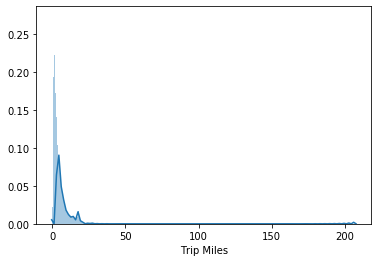

In [8]:
sns.distplot(df_raw["Trip Miles"], bins = np.arange(0, 50, 0.5).tolist())

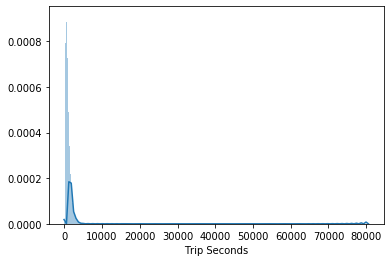

In [10]:
sns.distplot(df_raw['Trip Seconds'], bins = np.arange(0, 7200, 60).tolist())

In [11]:
df_raw['Fare'].max()

447.5

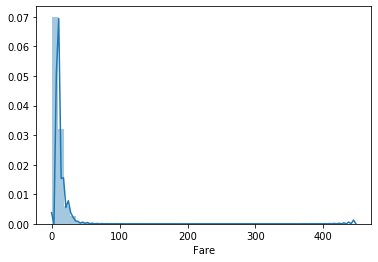

In [12]:
sns.distplot(df_raw['Fare'])

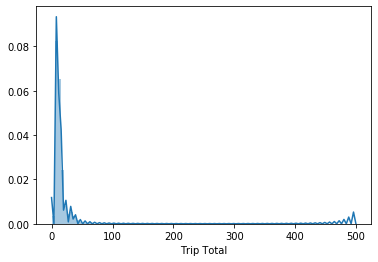

In [13]:
#this is the total cost of the trips
sns.distplot(df_raw['Trip Total'], bins = np.arange(0, 210, 5).tolist())

# Make some TOD visualizations
### for proposal ppt

In [ ]:
1 - 8pm-6am
2 - 6am-7am
3 - 7am-9am
4 - 9am-10am
5 - 10am-2pm
6 - 2pm-4pm
7 - 4pm-6pm
8 - 6pm-8pm

In [14]:
df_raw['ALL_TRIPS_NO_SUPPRESSED'] = df_raw.PRIVATE_TRIPS + df_raw.SHARED_TRIPS


In [19]:
tod_sum_df = df_raw.groupby(by = 'TOD', as_index = False).sum()

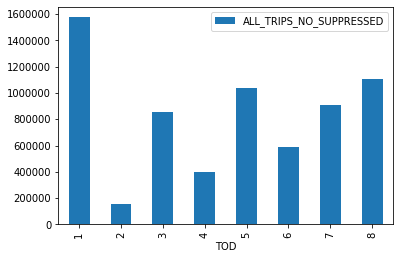

In [20]:
#this is total number of trips for each TOD
#I add in the suppressed trips down below... use that graph


#tod_sum_df.plot(kind = 'bar', x = 'TOD', y = 'ALL_TRIPS_NO_SUPPRESSED')

In [21]:
tod_avg_df = df_raw.groupby(by = 'TOD', as_index = False).mean()

In [24]:
#this is average number of trips for each OD pair within each TOD
#doesnt work right with the raw data... all are 1
#tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'ALL_TRIPS_NO_SUPPRESSED')

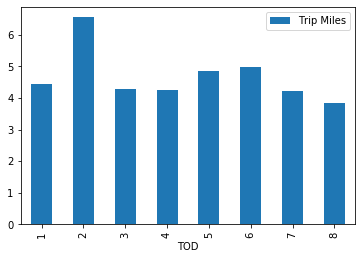

In [25]:
tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'Trip Miles')

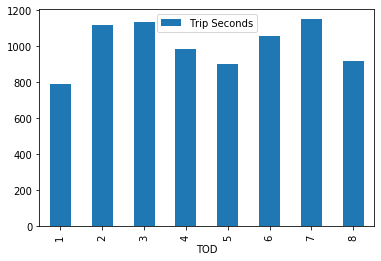

In [26]:
tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'Trip Seconds')

In [29]:
df_filtered = df_raw[df_raw['Trip Seconds'] <= 7200]
df_filtered = df_filtered[df_filtered['Trip Miles'] <= 50]

In [30]:
tod_df = pd.DataFrame()
variables = ['Trip Miles', 'Trip Seconds']

In [33]:
#generate stats for TOD stats table for proposal
for var in variables:   
    tod_df['TOD'] = tods
    min_col = df_filtered[[var, 'TOD']].groupby(by = 'TOD', as_index = False).min()
    tod_df['Min'] = min_col[var]

    max_col = df_filtered[[var, 'TOD']].groupby(by = 'TOD', as_index = False).max()
    tod_df['Max'] = max_col[var]

    avg_col = df_filtered[[var, 'TOD']].groupby(by = 'TOD', as_index = False).mean()
    tod_df['Average'] = avg_col[var]

    sum_col = df_filtered[[var, 'TOD']].groupby(by = 'TOD', as_index = False).sum()
    tod_df['Sum'] = sum_col[var]

    tod_df.to_csv(var +'_stats.csv')

In [41]:
# do the trip totals with the processed data so that it includes suppressed data and processed into average weekday 
## 
var = 'ALL_TRIPS'

tod_df['TOD'] = tods

min_col = df_final[[var, 'TOD']].groupby(by = 'TOD', as_index = False).min()
tod_df['Min'] = min_col[var]

max_col = df_final[[var, 'TOD']].groupby(by = 'TOD', as_index = False).max()
tod_df['Max'] = max_col[var]

avg_col = df_final[[var, 'TOD']].groupby(by = 'TOD', as_index = False).mean()
tod_df['Average'] = avg_col[var]

sum_col = df_final[[var, 'TOD']].groupby(by = 'TOD', as_index = False).sum()
tod_df['Sum'] = sum_col[var]

tod_df.to_csv(var +'_stats.csv')

# Make some DOW visualizations
### for proposal ppt

In [43]:
df_raw.DOW.unique()

array([4, 2, 1, 3, 0], dtype=int64)

In [45]:
variables = ['Trip Miles', 'Trip Seconds', 'ALL_TRIPS_NO_SUPPRESSED']

In [46]:
#generate stats for TOD stats table for proposal
for var in variables:   
    tod_df['TOD'] = tods
    min_col = df_filtered[[var, 'DOW']].groupby(by = 'DOW', as_index = False).min()
    tod_df['Min'] = min_col[var]

    max_col = df_filtered[[var, 'DOW']].groupby(by = 'DOW', as_index = False).max()
    tod_df['Max'] = max_col[var]

    avg_col = df_filtered[[var, 'DOW']].groupby(by = 'DOW', as_index = False).mean()
    tod_df['Average'] = avg_col[var]

    sum_col = df_filtered[[var, 'DOW']].groupby(by = 'DOW', as_index = False).sum()
    tod_df['Sum'] = sum_col[var]

    tod_df.to_csv(var +'_stats.csv')

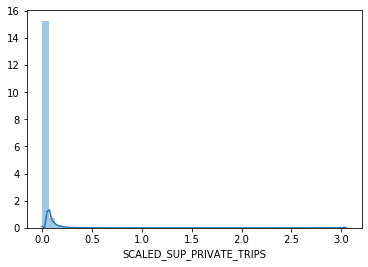

In [45]:
sns.distplot(df_final['SCALED_SUP_PRIVATE_TRIPS'])

In [50]:
sup_trips.SCALED_SUP_PRIVATE_TRIPS.max()

3.051531195980953

In [74]:
#the outlier OD-tods with more than 100 trips are all going to (most during am) or coming from (most during pm) the downtown core
df_final[df_final['ALL_TRIPS'] >100][['Pickup Census Tract', 'Dropoff Census Tract','TOD','Trip Miles']].astype(str)

,Pickup Census Tract,Dropoff Census Tract,TOD,Trip Miles
172496,17031081403.0,17031839100.0,3,1.6339446653505498
172789,17031081500.0,17031839100.0,3,1.3513655163307625
173278,17031081700.0,17031839100.0,3,1.0472676449888945
173552,17031081800.0,17031839100.0,3,1.2225135768323332
198110,17031320100.0,17031839100.0,3,1.2461411679778813
198924,17031330100.0,17031839100.0,3,2.113814056423688
221541,17031833100.0,17031839100.0,3,1.5283543180868921
314103,17031081800.0,17031839100.0,5,1.1832413484579511
344028,17031320100.0,17031839100.0,5,1.0860636299188182
370728,17031833000.0,17031839100.0,5,1.470509705911243


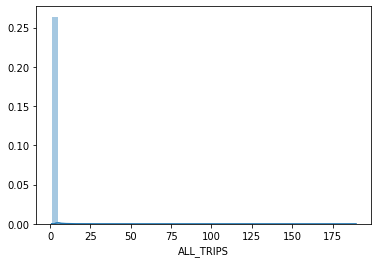

In [44]:
sns.distplot(df_final['ALL_TRIPS'])

In [75]:
df_final.head()

,Pickup Census Tract,Dropoff Census Tract,MONTH,DAY,Trip Seconds,Trip Miles,Fare,Tip,Additional Charges,Trip Total,PRIVATE_TRIPS,SHARED_TRIPS,Trips Pooled,TOD,GEOID_PICKUP,GEOID_DROPOFF,SCALED_SUP_PRIVATE_TRIPS,SCALED_SUP_SHARED_TRIPS,ALL_TRIPS
0,1.703101e+10,1.703101e+10,1.437500,14.625000,397.496875,1.235417,4.580729,0.770833,2.276719,7.628281,2.005081,0.675828,1.937500,1,1.703101e+10,1.703101e+10,0.505081,0.238328,2.680909
1,1.703101e+10,1.703101e+10,1.500000,15.269231,275.250000,1.009615,3.605769,0.076923,2.400962,6.083654,0.840168,0.515324,1.576923,1,1.703101e+10,1.703101e+10,0.032476,0.015324,1.355493
2,1.703101e+10,1.703101e+10,1.400000,16.100000,236.200000,0.570000,3.000000,0.100000,2.035000,5.135000,0.422509,0.810621,1.400000,1,1.703101e+10,1.703101e+10,0.022509,0.010621,1.233130
3,1.703101e+10,1.703101e+10,1.454545,14.272727,206.136364,0.718182,3.409091,0.090909,2.086364,5.586364,1.847285,0.806334,1.454545,1,1.703101e+10,1.703101e+10,0.938195,0.442698,2.653620
4,1.703101e+10,1.703101e+10,1.714286,10.142857,370.738095,1.483333,5.119048,0.595238,1.453571,7.167857,0.707765,0.740893,1.357143,1,1.703101e+10,1.703101e+10,0.207765,0.098036,1.448658


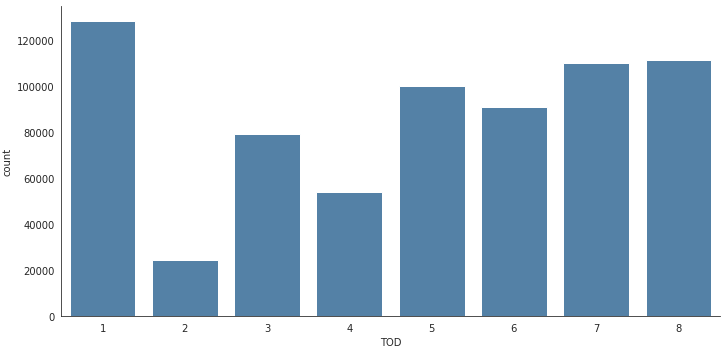

In [81]:
with sns.axes_style('white'):
    g = sns.factorplot("TOD", data=df_final[['ALL_TRIPS','TOD']], aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=1)

In [94]:
tod_sum_df = df_final.groupby(by = 'TOD', as_index = False).sum()

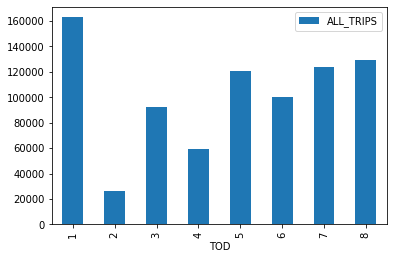

In [99]:
#this is total number of trips for each TOD
tod_sum_df.plot(kind = 'bar', x = 'TOD', y = 'ALL_TRIPS')

In [103]:
tod_avg_df = df_final.groupby(by = 'TOD', as_index = False).mean()

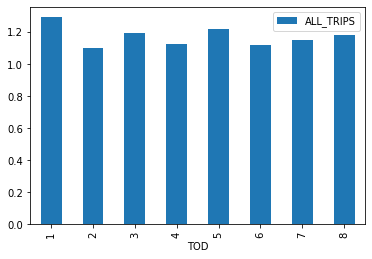

In [104]:
#this is average number of trips for each OD pair within each TOD
tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'ALL_TRIPS')

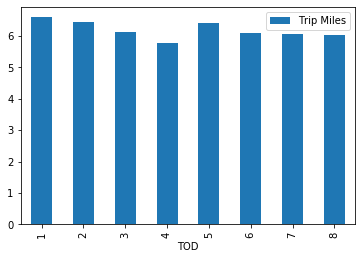

In [105]:
tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'Trip Miles')

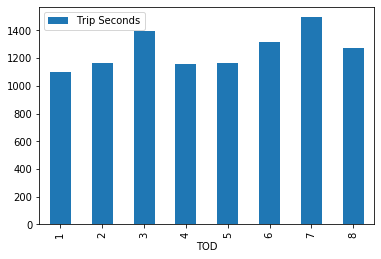

In [106]:
tod_avg_df.plot(kind = 'bar', x = 'TOD', y = 'Trip Seconds')

In [ ]:
    TODs
1 - 8pm-6am
2 - 6am-7am
3 - 7am-9am
4 - 9am-10am
5 - 10am-2pm
6 - 2pm-4pm
7 - 4pm-6pm
8 - 6pm-8pm

# Data Accuracy Check

In [ ]:
df = pd.read_hdf('C:/Workspace/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/Chicago_TNC_Trips_20.H5', key = 'Weekday_' + str(3))

In [14]:
jan_feb = df[df['MONTH'].isin([1,2])]

In [16]:
miles_over_50 = jan_feb[jan_feb['Trip Miles'] > 50]

In [17]:
len(miles_over_50)

77

In [18]:
miles_over_50.to_csv('Trips_Over_50_Miles.csv')

In [19]:
fare_0 = jan_feb[jan_feb['Fare'] == 0]

In [39]:
fare_0.to_csv('Fare_0_trips.csv')

In [41]:
jan_feb[(jan_feb['Trip Start Timestamp'] == '2019-01-15 08:30:00')&(jan_feb['Pickup Census Tract'] == 17031839700)&(jan_feb['Dropoff Census Tract'] == 17031320100)]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,YEAR,MONTH,DOW,HOUR
9133667,2019-01-15 08:30:00,2019-01-15 09:00:00,1679.0,5.2,1.703184e+10,1.703132e+10,0.0,0.0,0.67,0.67,True,2.0,2019,1,1,8


In [42]:
miles_over_50.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,YEAR,MONTH,DOW,HOUR
9285742,2019-01-24 08:15:00,2019-01-24 10:30:00,8068.0,58.1,1.703132e+10,1.703184e+10,152.5,0.0,2.55,155.05,False,1.0,2019,1,3,8
9764265,2019-01-01 08:45:00,2019-01-01 10:45:00,7752.0,90.7,1.703108e+10,1.703108e+10,112.5,21.0,5.50,139.00,False,1.0,2019,1,1,8
10872560,2019-02-21 07:45:00,2019-02-21 09:45:00,7645.0,51.7,1.703184e+10,1.703184e+10,80.0,11.0,3.30,94.30,False,1.0,2019,2,3,7
11963121,2019-02-01 08:15:00,2019-02-01 10:00:00,6133.0,53.9,1.703184e+10,1.703128e+10,75.0,0.0,2.55,77.55,False,1.0,2019,2,4,8
12646541,2019-01-25 08:30:00,2019-01-25 10:30:00,7135.0,83.4,1.703108e+10,1.703183e+10,102.5,0.0,2.55,105.05,False,1.0,2019,1,4,8


In [45]:
jan_feb[jan_feb['Trip Total'] == 0]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,YEAR,MONTH,DOW,HOUR
30217883,2019-01-28 07:30:00,2019-01-28 07:45:00,959.0,2.0,1.703108e+10,1.703107e+10,0.0,0.0,0.0,0.0,True,6.0,2019,1,0,7


In [44]:
len(jan_feb[jan_feb['Fare'] == 0])

32806

In [47]:
trips_5hrs_moore = jan_feb[jan_feb['Trip Seconds'] >= 18000]

In [48]:
trips_5hrs_moore.to_csv('trips_over_5hrs.csv')